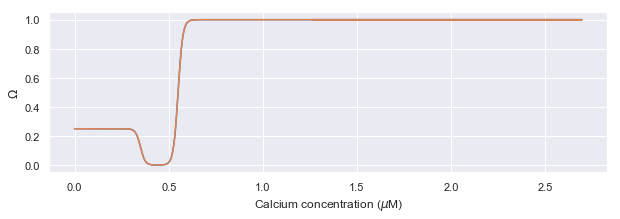

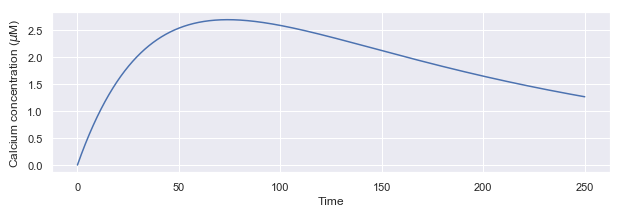

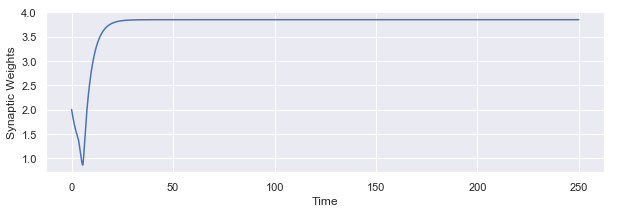

In [2]:
##################################################################################################
############################## NMDAR based synaptic plasticity ####################################
##################################################################################################
############################### Model is based on paper by Shouval et al. 2002 ########################
##############################################################################################

############################### Ca2+ control hypothesis ##########################################
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint

######## Assume Voltage Clamp method, the potential of the post synaptic neuron is clamped at Vm ###########

Vm = -20 #mV

##Defining parameters
###################### Calcium parameters #######################
tauCa = 50 #ms
ECa = 130 #mV
################## Omega - Function ###########################
alpha1 = 0.35
alpha2 = 0.55
beta1 = 80
beta2 = 80
################## NMDA Current ###############################
P0 = 0.7
GNMDA = -1/500#1350 #uM/ms.mV
If = 0.4  ##Can be changed
Is = 0.5  ##Can be changed
tauf = 50 #ms
taus = 200 #ms
## If + Is = 1
############### Learning Rate (Ca2+ dependent) ################
p1 = 0.1 #s
p2 = 0.1e4
p3 = 3 
p4 = 1 #s
k = 0.26 #same as lambda in the paper, 0.26 is a good choice for lambda


################### Defining Functions ##################
def sig(x, beta):
    return np.exp(beta*x)/(1 + np.exp(beta*x))
#sig = lambda x, beta: np.exp(beta*x)/(1 + np.exp(beta*x))
def Omega(Ca):
    return 0.25 + sig(Ca - alpha2, beta2) - 0.25*sig(Ca - alpha1, beta1)
    
def B(V):
    return 1/(1 + np.exp(-0.062*V)/3.57)

def INMDA(V, t):
        return P0*GNMDA*(If*np.exp(-t/tauf) + (1 - If)*np.exp(-t/taus))*B(V)*(V - ECa)
      
def eta(Ca): ##Learning Rate
    return ((p1/(p2)) + p4)**(-1)

def Voltage():
    return Vm

def theta(x):
    if(x>0):
        return 1
    else:
        return 0
    
######################## State Function ####################

def dXdt(X, t):
    Ca = X[0]
    w = X[1]
    
    dCadt = INMDA(Voltage(), t) - Ca/tauCa
    dwdt = eta(Ca)*(Omega(Ca) - k*w ) #converting seconds to milliseconds
    
    return dCadt, dwdt

###################### passing values ######################
epsilon = 0.01
t = np.arange(0, 250., epsilon)
x0 = [0, 2] #uM, just a number signifying the weight

##The zero of the calcium concentration is taken at the lower threshold (~10uM) as a referenece
sol = odeint(dXdt, x0, t)   #column 1: Calcium concentration, column 2: weights
omegaTrace = np.zeros(sol.shape)
ITrace = np.zeros(sol.shape)

for i in range(t.shape[0]):
    omegaTrace[i] = Omega(sol[i,0])
    ITrace[i] = INMDA(Vm, t[i])

sns.set()
####### Omega ###########
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(sol[:,0], omegaTrace)
plt.xlabel("Calcium concentration ($\mu$M)")
plt.ylabel('$\Omega$')
#plt.grid()
#plt.savefig('Omega_Funtion')
plt.show()
######## Calcium as a function of time ##########
plt.figure(figsize=(10,10))
plt.subplot(3,1,2)
plt.plot(t, sol[:,0])
plt.xlabel("Time")
plt.ylabel('Calcium concentration ($\mu$M)')
#plt.grid()
#plt.savefig('Calcium_conc')
plt.show()
######## Weights #########################
plt.figure(figsize=(10,10))
plt.subplot(3,1,3)
plt.plot(t, sol[:,1])
plt.xlabel("Time")
plt.ylabel('Synaptic Weights')
#plt.grid()
#plt.savefig('weights')
plt.show()


In [3]:
############################### Weights as a function of postsynaptic membrane potential ########################

# The idea is to keep the potential of the postsynaptic neuron fixed at some value for the entire trial
# The postsynaptic potential is taken from Vm to dataPoints + Vm from trial 1 to trial 'dataPoints'
# The steady state value of the weights is extracted
# Depending on epsilon, the index for steady value of weight will vary
# 1490th row in wTrace implies 150ms later

dataPoints = 70
Vm = -75 #mV
def theta(x):
    if(x>0):
        return 1
    else:
        return 0
######################### Defining a function which inputs a voltage depending on the iteration #################
def Voltage(k):
    return Vm + k

######################### Overloaded State function which takes in additional parameter: ONLY FOR THIS CASE ############
def dXdt(X, t, v, dummy):
    Ca = X[0]
    w = X[1]
    
    dCadt = INMDA(Voltage(v), t) - Ca/tauCa
    dwdt = eta(Ca)*(Omega(Ca) - k*w ) #converting seconds to milliseconds
    
    return dCadt, dwdt
################################### EXPENSIVE LOOP #################################################
wTrace = np.zeros((t.shape[0], dataPoints))

for vStep in range(dataPoints):
    sol2 = odeint(dXdt, x0, t, args = (vStep, 0))
    wTrace[:,vStep] = sol2[:,1]
##################################################################################################    
print('done!')    

done!


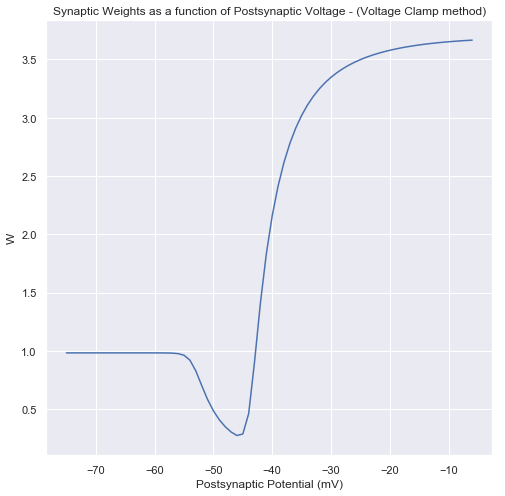

In [4]:
W = np.zeros(dataPoints)
W[:] = wTrace[1499,:]
vTrace = Vm + np.arange(dataPoints)


plt.figure(figsize=(8,8))
plt.title("Synaptic Weights as a function of Postsynaptic Voltage - (Voltage Clamp method)")
sns.lineplot(vTrace, W)
plt.xlabel("Postsynaptic Potential (mV)")
plt.ylabel("W")
#plt.grid()
plt.savefig('weights_volt_change')
plt.show()


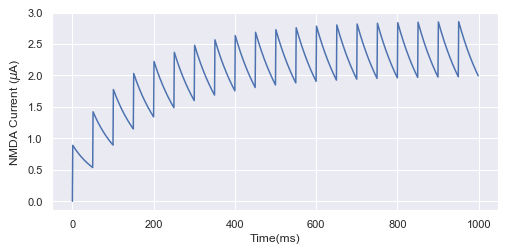

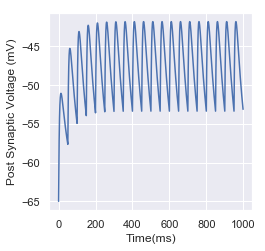

In [6]:
########################## Weights as function of input frequency ##########################
f = 20.0 #Hz
tSpike = np.arange(0., 1., 1/f)
tSpike*=1000
#print(tSpike)
######################### Time Series for Frequency dependence of synaptic strength ###########
t1 = np.arange(0,1000)
##################### Cell Potential Parameters (same as EPSP) ##########################
tau1EP = 50 #ms
tau2EP = 5 #ms
sc = 20 #mV
s = 1 #mV
Vrest = -65 #mV
# def theta(x):
#     if(x>0):
#         return 1
#     else:
#         return 0
    
#################### Postsynaptic cell potential modelling #########################
def cellPot(t):
    accV = 0  ##Since 'sum' is a keyword, I'm going with 'accumulate'
    for i in range(tSpike.shape[0]):
        accV += theta(t - tSpike[i])*(np.exp(-(t - tSpike[i])/tau1EP) - np.exp(-(t - tSpike[i])/tau2EP))
               
    return Vrest + sc*accV
    

################### NMDA current due to glutamate bursts at every pre-APs ################
def iNMDA(t):
    accI = 0
    for i in range(tSpike.shape[0]):
        accI += If*theta(t - tSpike[i])*np.exp(-(t - tSpike[i])/tauf) + Is*theta(t - tSpike[i])*np.exp(-(t - tSpike[i])/taus)
    
    return accI

epspTr = np.zeros((t1.shape[0]))   #VI trace of the post synaptic cell
iTr = np.zeros((t1.shape[0]))


for k in range(t1.shape[0]):
    epspTr[k] = cellPot(t1[k])
    iTr[k] = iNMDA(t1[k])


######################### Integrated NMDA Current Response ########################
plt.figure(figsize=(8,8))    
plt.subplot(2,1,1)
plt.plot(t1, iTr)
plt.xlabel('Time(ms)')
plt.ylabel('NMDA Current ($\mu$A)')
#plt.savefig("Integrated_NMDA")
plt.show()
###################### Post Synaptic Voltage response to input spike train #####################
plt.figure(figsize=(8,8))
plt.subplot(2,2,1)
plt.plot(t1, epspTr)
plt.xlabel('Time(ms)')
plt.ylabel('Post Synaptic Voltage (mV)')
#plt.savefig("Post_synaptic_voltage")
plt.show()        

In [6]:
############################## Modifying the above part for a full frequency response ###########################

############################## Defining previous functions which accept tSpike as parameter #####################

def cellPot(t, tSpike):
    accV = 0  ##Since 'sum' is a keyword, I'm going with 'accumulate'
    for i in range(tSpike.shape[0]):
        accV += theta(t - tSpike[i])*(np.exp(-(t - tSpike[i])/tau1EP) - np.exp(-(t - tSpike[i])/tau2EP))
               
    return Vrest + sc*accV 

def iNMDA(V, t, tSpike):
    accI = 0
    for i in range(tSpike.shape[0]):
        accI += (If*theta(t - tSpike[i])*np.exp(-(t - tSpike[i])/tauf) + Is*theta(t - tSpike[i])*np.exp(-(t - tSpike[i])/taus))*B(V)*(V - ECa)
    
    return accI

maxFreq = 80 #Its a misnomer, its actually max frequency*4... got lazy to change variable name :P

############################ Modified State Function ####################################

def dYdt(Y, t, tSpike, dummy):
    Ca = Y[0]
    w = Y[1]
    
    dCadt = P0*GNMDA*iNMDA(cellPot(t, tSpike), t, tSpike) - Ca/tauCa
    dwdt = eta(Ca)*(Omega(Ca) - 0.4*w )/100 #converting seconds to milliseconds
    
    return dCadt, dwdt
    
y0 = [0,0]
#caTrace = np.zeros((t1.shape[0], maxFreq))
wTrace = np.zeros((t1.shape[0], maxFreq))
fTrace = np.zeros(maxFreq)
for i in range(maxFreq):
    f = (i+1)/4
    fTrace[i] = f
    tSpike = np.arange(0., 1., 1/f)
    tSpike*= 1000
    
    sol3 = odeint(dYdt, y0, t1, args = (tSpike, 0))
    
    wTrace[:,i] = sol3[:,1]
###########################################################################################    
print('done!!')

done!!


[0.55378131 0.55378131 0.55378131 0.55378131 0.55378131 0.55378131
 0.55378131 0.55378131 0.72575471 0.99375088 0.91218333 0.83571049
 0.81551541 0.81075047 0.80738276 0.80479442 0.89563813 1.07921964
 1.2277482  1.35083896 1.45863831 1.55617389 1.59416223 1.5629929
 1.70220171 1.83088095 1.89980606 1.94543848 1.97290669 1.98797187
 1.99964283 2.01014835 2.01984642 2.028846   2.03722036 2.04503119
 2.05233154 2.05916637 2.06557232 2.07157709 2.07719814 2.08244085
 2.08729732 2.0917463  2.09575645 2.09929385 2.10233386 2.10487304
 2.10693543 2.10857056 2.10984318 2.1108224  2.11157218 2.11214679
 2.11258946 2.11293348 2.11320367 2.11341859 2.11359174 2.11373318
 2.11385033 2.11394868 2.11403239 2.11410457 2.11416761 2.11422336
 2.11427326 2.11431843 2.11435979 2.11439806 2.11443385 2.11446762
 2.11449981 2.11453075 2.11456075 2.11459009 2.11461901 2.11464769
 2.1146764  2.11470528]


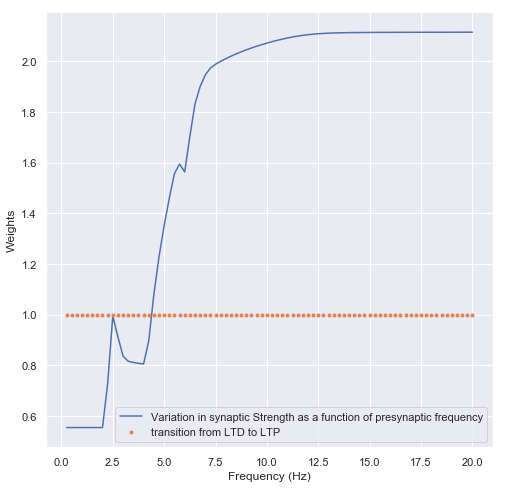

In [7]:
########################## Plotting ######################################################

W = np.zeros(maxFreq)
W[:] = wTrace[500, :]
print(W)

plt.figure(figsize=(8,8))
plt.plot(fTrace, W, label = 'Variation in synaptic Strength as a function of presynaptic frequency')
plt.plot(fTrace, np.ones(fTrace.shape[0]), '.', label = 'transition from LTD to LTP')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Weights')
#plt.savefig('w_vs_freq')
plt.legend()
plt.show()

In [16]:
f1 = open("Weights_Freq.txt", 'w')
np.savetxt("Weights_freq.txt", W, fmt = '%s')